In [39]:
setwd('/import/hd/sc')

In [40]:
mac = readRDS('./scRNA.macro.rds')

In [41]:
fib = readRDS('./scRNA.fibro.rds')

In [42]:
sce = merge(fib,mac)

In [43]:
table(sce$celltype)


      Granulo Inflamm.Macro   Inter fibro      LL fibro           MPC 
          368          2285          4492         10725         10184 
         Mono     Resid.mac      SPP1_mac          cDC1         preAD 
         2740          3115           159            59          7765 

In [47]:
library(CellChat)
library(patchwork)

In [50]:
packageVersion('CellChat')

[1] '2.1.2'

In [51]:
library(Seurat)

In [52]:
cellchat <- createCellChat(object = sce,
                           meta = sce@meta.data,
                           group.by = "celltype")
cellchat

CellChatDB <- CellChatDB.human
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling") 
# set the used database in the object
cellchat@DB <- CellChatDB.use

library(future)
cellchat <- subsetData(cellchat) 
# do parallel ，根据配置设置
plan(multisession, workers=20)
cellchat <- identifyOverExpressedGenes(cellchat)
#识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)

[1] "Create a CellChat object from a Seurat object"
The `data` slot in the default assay is used. The default assay is RNA 
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  Granulo Inflamm.Macro Inter fibro LL fibro MPC Mono Resid.mac SPP1_mac cDC1 preAD 


An object of class CellChat created from a single dataset 
 21825 genes.
 41892 cells. 
CellChat analysis of single cell RNA-seq data! 

ERROR: Error in smoothData(cellchat, adj = PPI.human): could not find function "smoothData"


In [60]:
#project gene expression data onto PPI (Optional: when running it, USER should set `raw.use = FALSE` in the function `computeCommunProb()` in order to use the projected data)
#cellchat <- smoothData(cellchat, adj = PPI.human)
cellchat <- projectData(cellchat, PPI.human)
library(future)
options(future.globals.maxSize= 4000000000)
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat <- filterCommunication(cellchat, min.cells = 3)
df.net <- subsetCommunication(cellchat,slot.name = "netP")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> Run CellChat on sc/snRNA-seq data <<< [2024-08-03 09:18:05]"
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2024-08-03 09:28:01]"


In [61]:
cellchat <- computeCommunProbPathway(cellchat)

cellchat <- aggregateNet(cellchat)

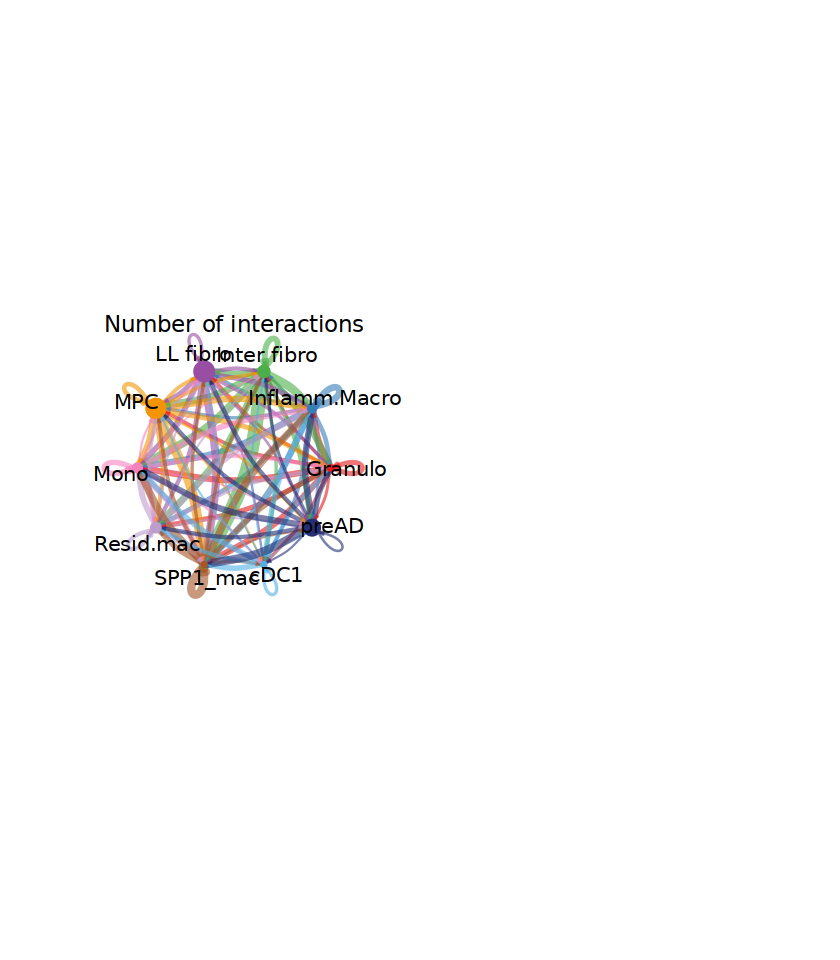

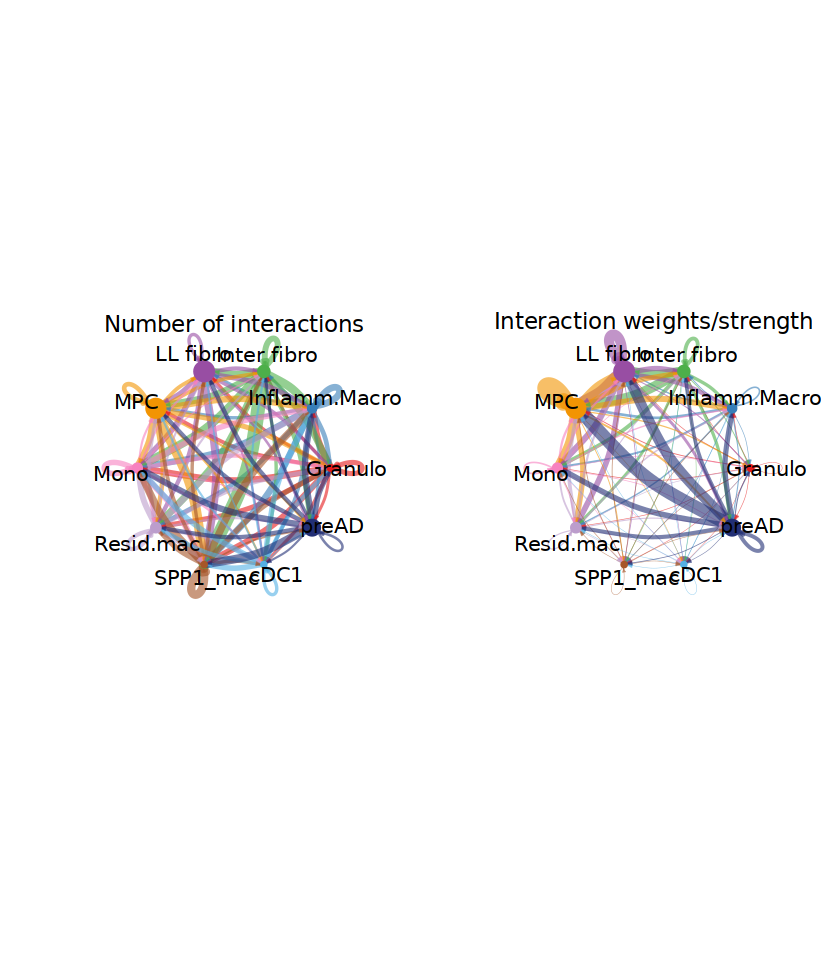

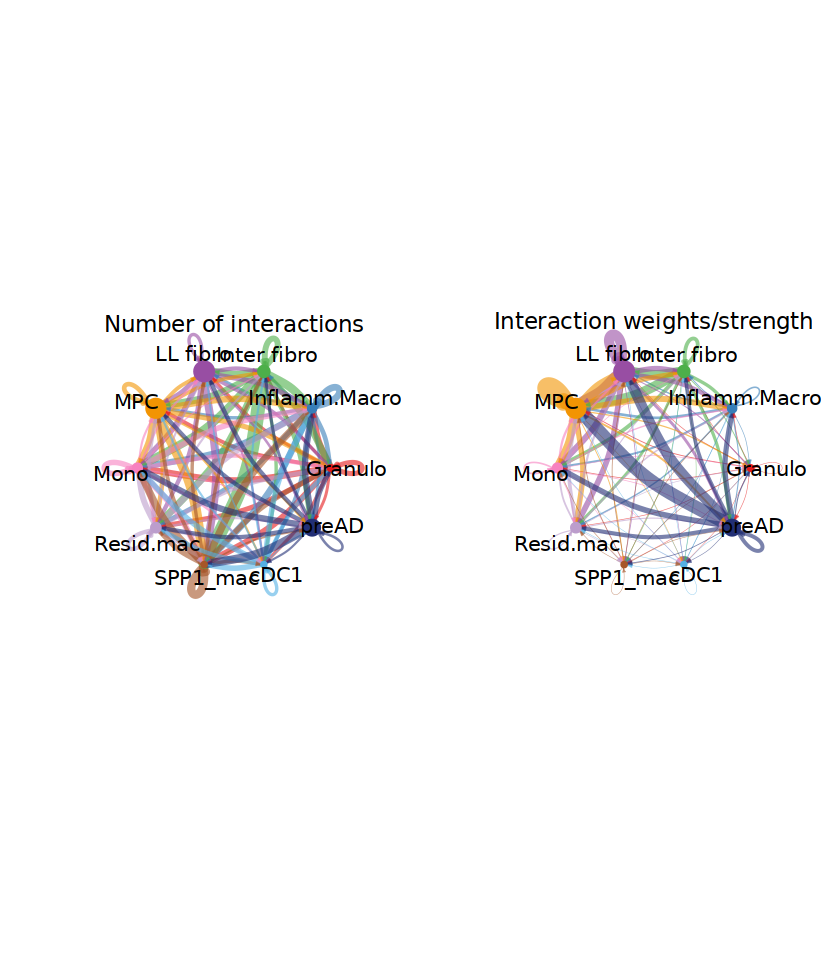

In [62]:
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, title.name = "Interaction weights/strength")

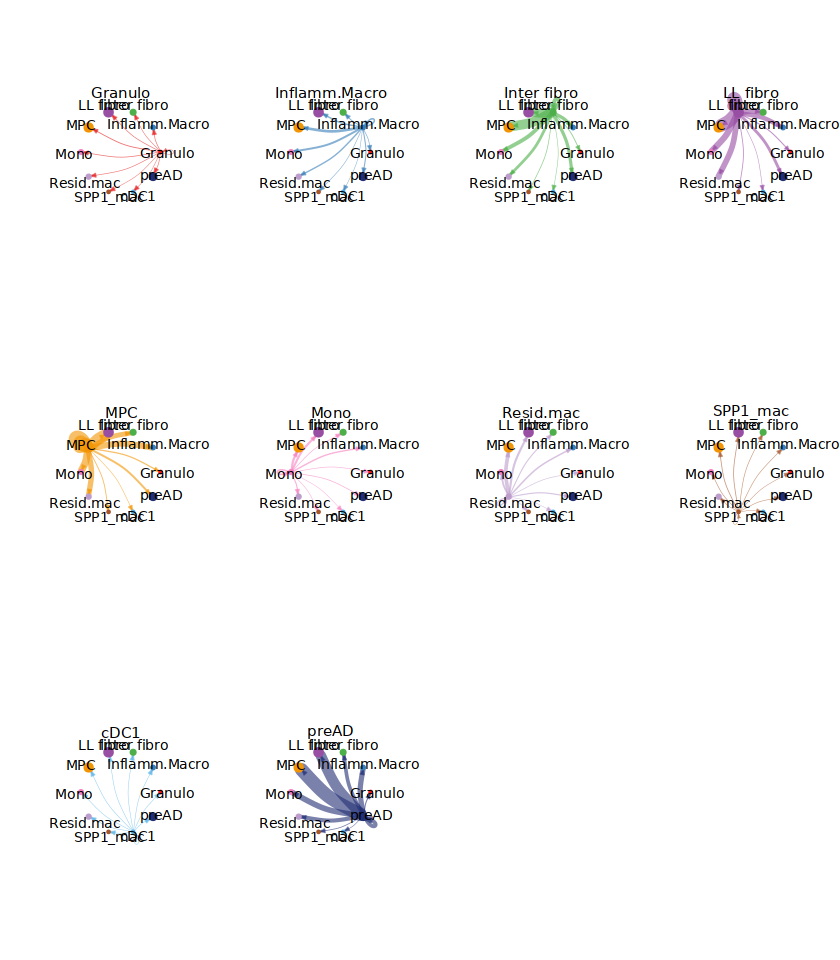

In [63]:
mat <- cellchat@net$weight
par(mfrow = c(3,4), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, edge.weight.max = max(mat), title.name = rownames(mat)[i])
}

In [64]:
pathways.show = cellchat@netP$pathways

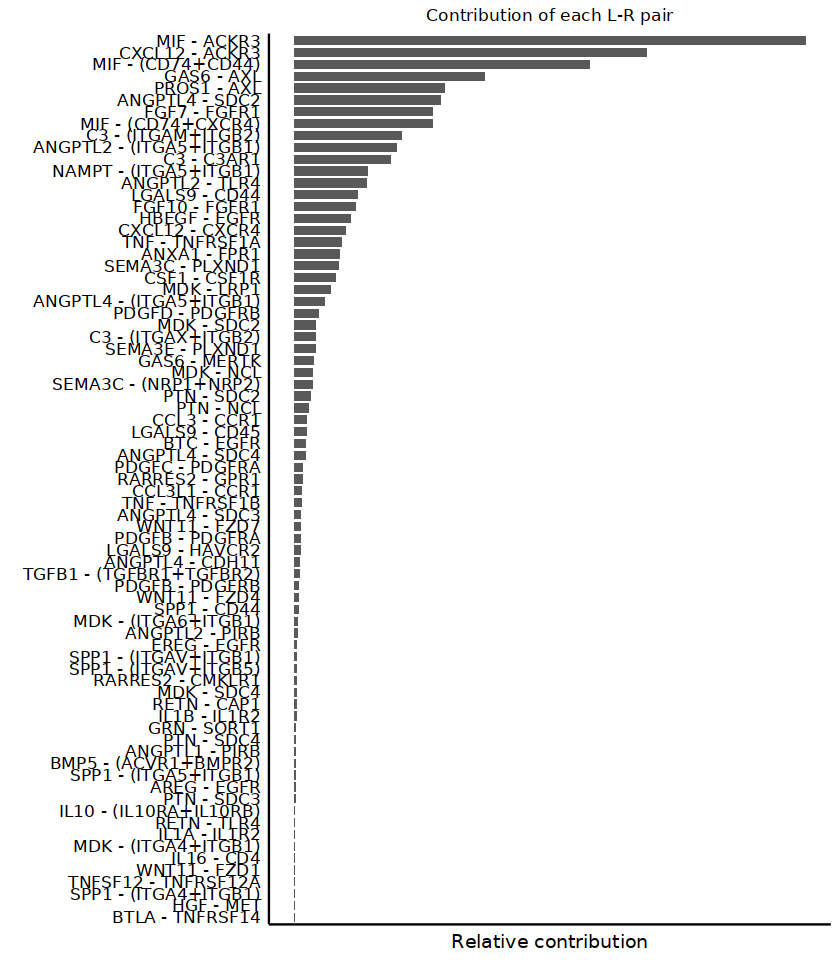

In [65]:
netAnalysis_contribution(cellchat, signaling = pathways.show)

Do heatmap based on a single object 




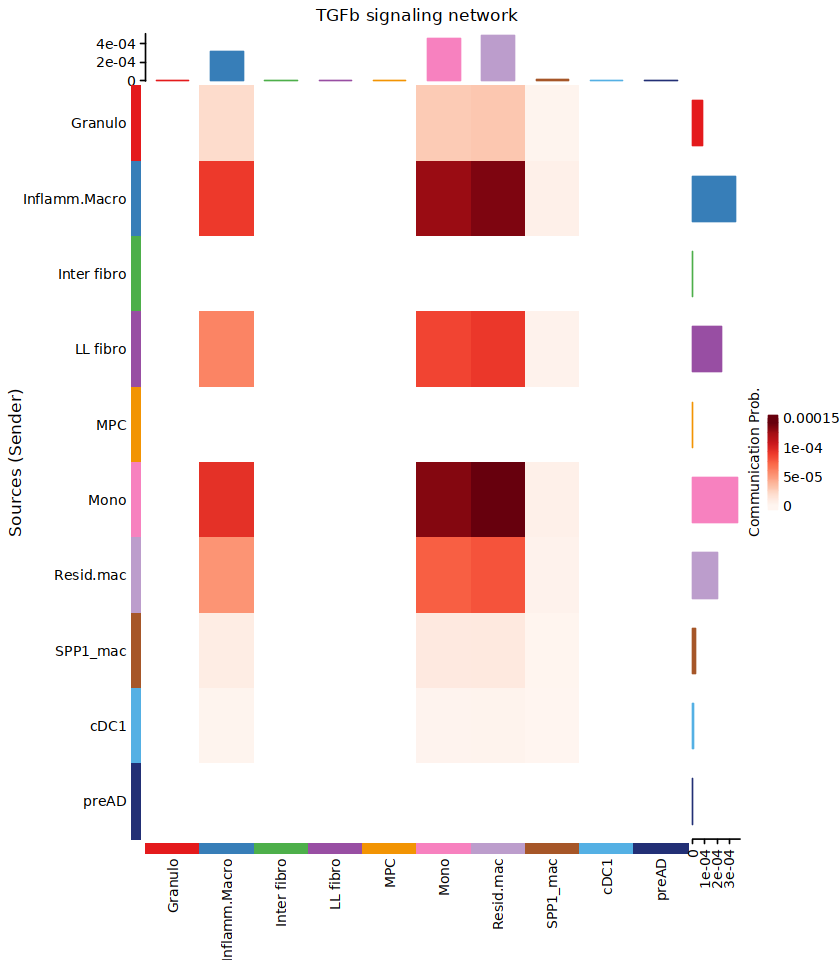

In [66]:
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = 'TGFb', color.heatmap = "Reds")

In [67]:
pathways.show

[1] "MIF"        "CXCL"       "ANGPTL"     "COMPLEMENT" "GAS"       
 [6] "FGF"        "PROS"       "SEMA3"      "GALECTIN"   "MK"        
[11] "VISFATIN"   "EGF"        "TNF"        "ANNEXIN"    "PDGF"      
[16] "CSF"        "PTN"        "CCL"        "ncWNT"      "CHEMERIN"  
[21] "SPP1"       "TGFb"       "RESISTIN"   "IL1"        "GRN"       
[26] "BMP"        "IL10"       "IL16"       "TWEAK"      "HGF"       
[31] "BTLA"

In [68]:
options(repr.plot.height = 8)

Comparing communications on a single object 




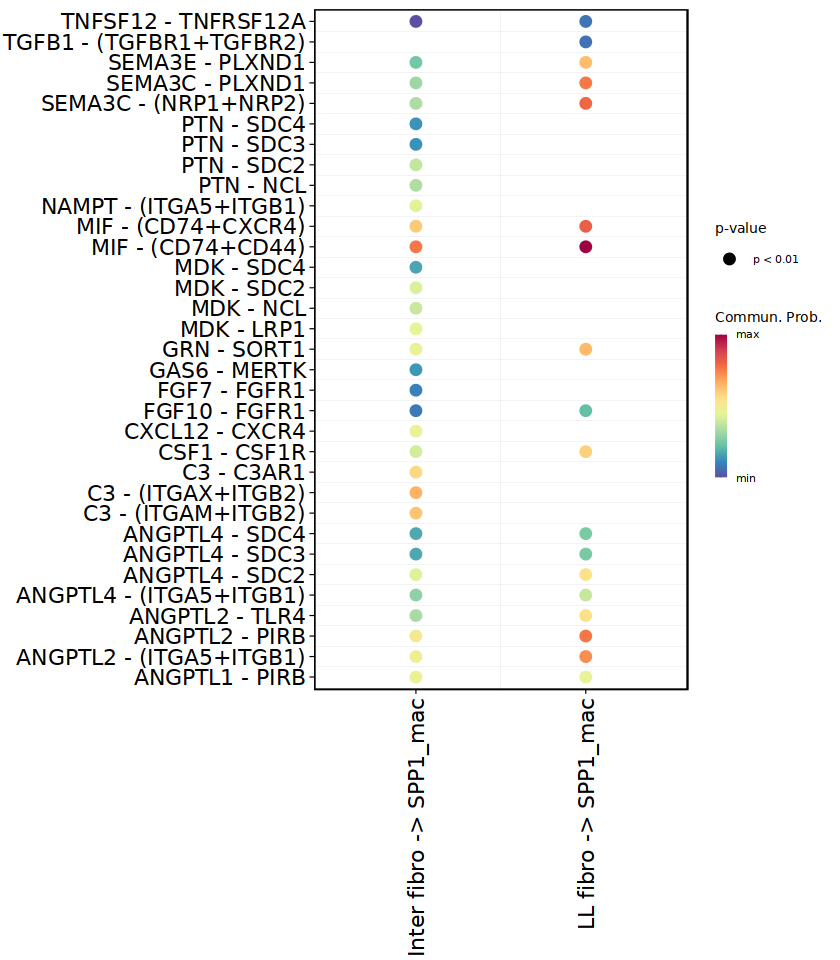

In [69]:
netVisual_bubble(cellchat,sources.use = c(3,4),font.size = 16, targets.use = c(8), remove.isolate = FALSE)